# Library Import Initiation

In [1]:
import pandas as pd
import math
import json
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import datetime

# Dataset Import

In [4]:
df1 = pd.read_csv("ad_performance_no_outliers_2.csv")
df2 = pd.read_csv("balanced_output_smote (1).csv")
df3 = pd.read_csv("balanced_output_smote(2).csv")

# Variables Define

In [5]:
num_cols = ["uv", "search", "ocr"]

cat_cols = ["material", "placement", "payment", "sellingpoint"]

# PROCESS FUNCS

## num_cols Scaling

In [6]:
def scale_with_robust_scaler(df, num_cols=num_cols):
    df_scaled = df[num_cols].copy()
    for col in num_cols:
        scaler_path = os.path.join("scalers", f"{col}_robust_scaler.pkl")
        scaler = joblib.load(scaler_path)
        df_scaled[col] = scaler.transform(df[[col]])
    return df_scaled

## cat_cols OneHotEncoding

In [7]:
def onehotencoding_with_encoder(df, cat_cols=cat_cols):
    df_cat = df[cat_cols].copy()
    # 加载已保存的OneHotEncoder
    encoder = joblib.load('onehot_encoder.pkl')

    # 对新数据进行编码（只需包含main_cat_cols的列）
    new_cat_encoded = encoder.transform(df_cat[cat_cols])

    # 转为DataFrame，列名与训练时一致
    new_cat_encoded_df = pd.DataFrame(
        new_cat_encoded,
        columns=encoder.get_feature_names_out(cat_cols),
        index=df_cat.index
    )
    return new_cat_encoded_df

## cat_cols Labelencoding

In [8]:
def encode_with_label_mapping(df, cat_cols, mapping_path='label_mapping.json'):
    # 读取映射文件
    with open(mapping_path, 'r', encoding='utf-8') as f:
        label_mapping = json.load(f)
    df_encoded = df[cat_cols].copy()
    for col in cat_cols:
        if col in label_mapping:
            df_encoded[col] = df_encoded[col].map(label_mapping[col])
        else:
            raise ValueError(f"列 {col} 不在 label_mapping.json 中")
    return df_encoded


## Merge dfs

In [9]:
def dataset_processing(dataf,label_method):
    num_df = scale_with_robust_scaler(dataf)
    if label_method == "onehot":
        cat_df = onehotencoding_with_encoder(dataf)
    elif label_method == "label":
        cat_df = encode_with_label_mapping(dataf, cat_cols)
    df_reg = pd.concat([num_df, cat_df], axis=1)
    df_moc = df_reg.drop(columns="ocr", axis=1)
    return df_moc, df_reg

# DATA SETS BUILDING

In [10]:
df_transformer_moc, df_xgb_reg = dataset_processing(df3, label_method="label")

# XGBoost-Regression

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [12]:
print(xgb.__version__)

3.0.2


In [13]:
y_xgb_reg = df_xgb_reg['ocr']                   # 回归目标
X_xgb_reg = df_xgb_reg.drop(columns="ocr")   # 这里填入你的所有可用数值特征（不要目标变量）

# 数据集划分
X_xgb_reg_train, X_xgb_reg_test, y_xgb_reg_train, y_xgb_reg_test = train_test_split(
    X_xgb_reg, y_xgb_reg, test_size=0.2, random_state=42
)

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# 参数空间
xgb_reg_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# XGBoost回归器
xgb_reg_base_model = xgb.XGBRegressor(
    random_state=42,
    objective='reg:squarederror' # 避免警告
)

# 随机搜索（100次迭代）
xgb_reg_search = RandomizedSearchCV(
    estimator=xgb_reg_base_model,
    param_distributions=xgb_reg_param_grid,
    n_iter=100,            # 搜索次数，调大更精细
    cv=5,                 # 3折交叉验证
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 搜索最优参数
xgb_reg_search.fit(X_xgb_reg_train, y_xgb_reg_train)

print("Best Params:", xgb_reg_search.best_params_)
print("Best CV Score:", -xgb_reg_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV Score: 0.016245571578362927


In [15]:
xgb_reg_search.best_params_

{'subsample': 0.6,
 'n_estimators': 500,
 'max_depth': 8,
 'learning_rate': 0.05,
 'colsample_bytree': 1.0}

In [16]:
# 用搜索得到的最佳参数训练新的XGBRegressor
xgb_final_model = xgb.XGBRegressor(
    **xgb_reg_search.best_params_,
    random_state=42,
    objective='reg:squarederror'
)

# 加入eval_set参数
xgb_final_model.fit(
    X_xgb_reg_train, y_xgb_reg_train,
    eval_set=[(X_xgb_reg_train, y_xgb_reg_train), (X_xgb_reg_test, y_xgb_reg_test)],
    verbose=True
)


[0]	validation_0-rmse:0.61567	validation_1-rmse:0.62094
[1]	validation_0-rmse:0.58926	validation_1-rmse:0.59433
[2]	validation_0-rmse:0.56451	validation_1-rmse:0.56984
[3]	validation_0-rmse:0.54103	validation_1-rmse:0.54645
[4]	validation_0-rmse:0.51835	validation_1-rmse:0.52361
[5]	validation_0-rmse:0.49730	validation_1-rmse:0.50233
[6]	validation_0-rmse:0.47745	validation_1-rmse:0.48265
[7]	validation_0-rmse:0.45809	validation_1-rmse:0.46303
[8]	validation_0-rmse:0.44046	validation_1-rmse:0.44537
[9]	validation_0-rmse:0.42303	validation_1-rmse:0.42786
[10]	validation_0-rmse:0.40710	validation_1-rmse:0.41170
[11]	validation_0-rmse:0.39168	validation_1-rmse:0.39628
[12]	validation_0-rmse:0.37716	validation_1-rmse:0.38183
[13]	validation_0-rmse:0.36324	validation_1-rmse:0.36781
[14]	validation_0-rmse:0.35092	validation_1-rmse:0.35549
[15]	validation_0-rmse:0.33850	validation_1-rmse:0.34322
[16]	validation_0-rmse:0.32651	validation_1-rmse:0.33099
[17]	validation_0-rmse:0.31548	validation

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


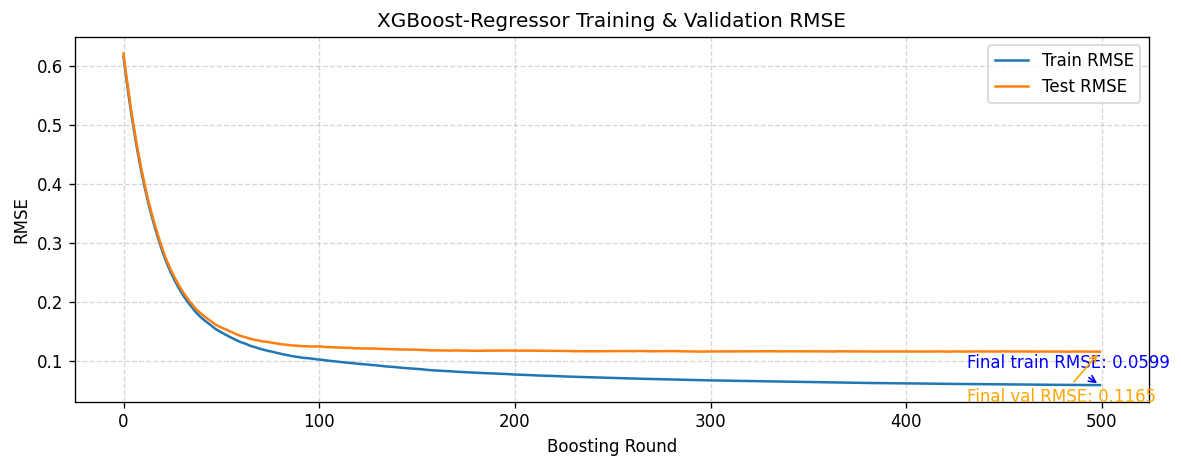

In [17]:
# 绘制训练集和测试集的eval loss曲线
evals_result = xgb_final_model.evals_result()

plt.figure(figsize=(10, 4), dpi=120)
plt.plot(evals_result['validation_0']['rmse'], label='Train RMSE')
plt.plot(evals_result['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
final_train_loss = evals_result['validation_0']['rmse'][-1]
final_val_loss = evals_result['validation_1']['rmse'][-1]
plt.annotate(f'Final train RMSE: {final_train_loss:.4f}', 
             xy=(len(evals_result['validation_0']['rmse'])-1, final_train_loss), 
             xytext=(-80, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='blue'), color='blue')
plt.annotate(f'Final val RMSE: {final_val_loss:.4f}', 
             xy=(len(evals_result['validation_1']['rmse'])-1, final_val_loss), 
             xytext=(-80, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='orange'), color='orange')
plt.title('XGBoost-Regressor Training & Validation RMSE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
with open('BestParamsXGBReg.json', 'w', encoding='utf-8') as f:
    json.dump(xgb_reg_search.best_params_, f, ensure_ascii=False, indent=4)

In [19]:
# 用最优参数建最终模型
xgb_reg_best_model = xgb_reg_search.best_estimator_

train_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

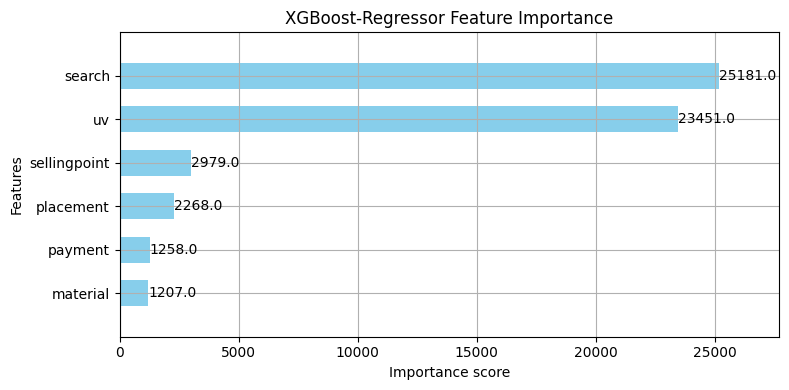

In [20]:
# XGBoost特征重要性可视化

ax = xgb.plot_importance(
    xgb_final_model,
    max_num_features=15,
    importance_type='weight',
    height=0.6,
    color='skyblue'  
)
ax.figure.set_size_inches(8, 4)  # 直接设置图像宽高
plt.title('XGBoost-Regressor Feature Importance')
plt.tight_layout()
plt.show()

In [21]:
# 预测
y_xgb_reg_pred = xgb_final_model.predict(X_xgb_reg_test)
# y_xgb_reg_pred = xgb_reg_best_model.predict(X_xgb_reg_test)

# 评估
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_xgb_reg_test, y_xgb_reg_pred)
mse = mean_squared_error(y_xgb_reg_test, y_xgb_reg_pred)
rmse = np.sqrt(mse)
r2_score = r2_score(y_xgb_reg_test, y_xgb_reg_pred)


print(f'XGBoost-Regression Evaluation({xgb_reg_search.best_params_}):')
# print('Train Time:', train_time)
print('MAE:', f"{mae:.6f}")
print('MSE:', f"{mse:.6f}")
print('RMSE:', f"{rmse:.6f}")
print('R2:', f"{r2_score:.6f}")

XGBoost-Regression Evaluation({'subsample': 0.6, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}):
MAE: 0.043550
MSE: 0.013563
RMSE: 0.116460
R2: 0.967785


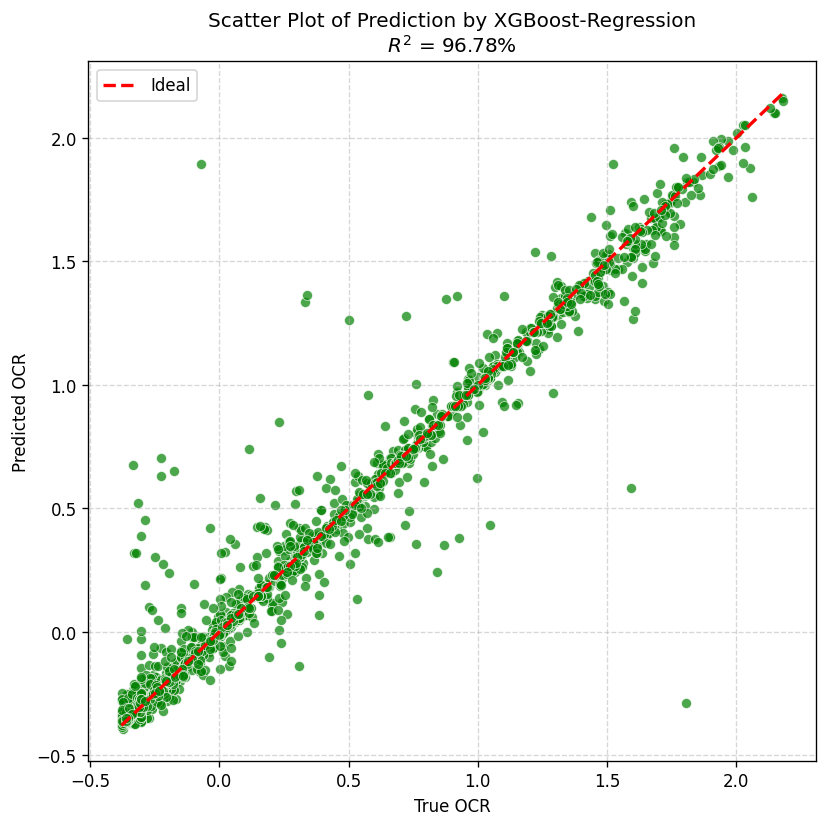

In [22]:
# 可视化：真实值 vs 预测值散点图
plt.figure(figsize=(7, 7), dpi=120)
sns.scatterplot(x=y_xgb_reg_test, y=y_xgb_reg_pred, color='green', alpha=0.7)
plt.plot([y_xgb_reg_test.min(), y_xgb_reg_test.max()], [y_xgb_reg_test.min(), y_xgb_reg_test.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('True OCR')
plt.ylabel('Predicted OCR')
plt.title(
    f'Scatter Plot of Prediction by XGBoost-Regression\n'
    # f'{train_time}\n'
    + r"$R^2$" + f" = {r2_score*100:.2f}%")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


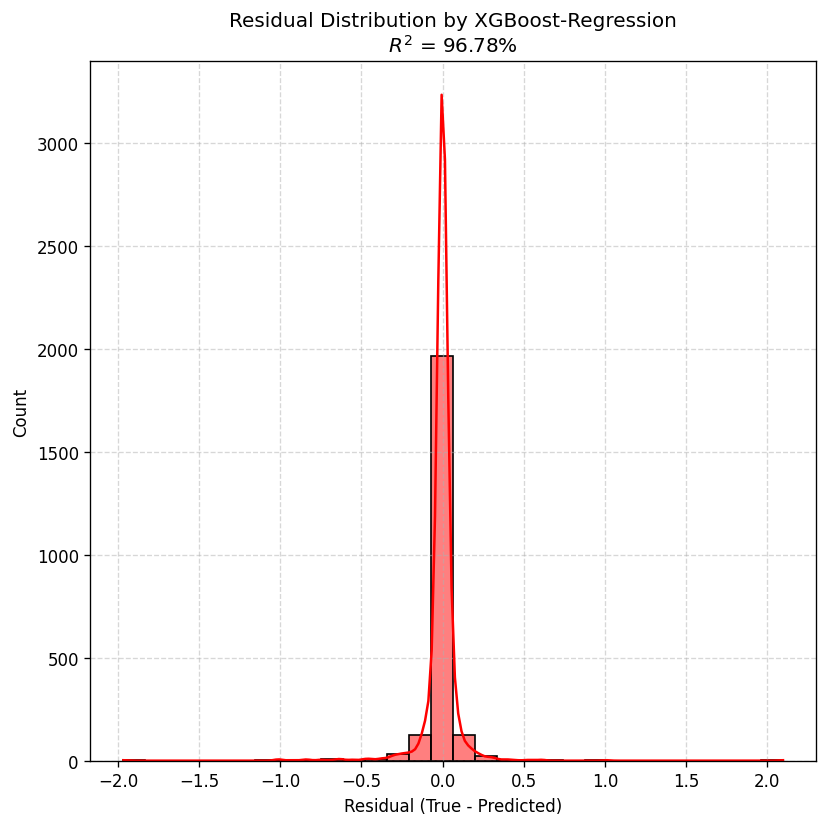

In [23]:
# 可视化：残差分布
residuals = y_xgb_reg_test - y_xgb_reg_pred
plt.figure(figsize=(7, 7), dpi=120)
sns.histplot(residuals, bins=30, kde=True, color='red')
plt.xlabel('Residual (True - Predicted)')
plt.title(f'Residual Distribution by XGBoost-Regression\n{r"$R^2$"} = {r2_score*100:.2f}%')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
# Save Model

model_save_time = train_time.replace(" ", "_").replace(":", "-")
joblib.dump(xgb_reg_best_model, f'xgb_reg_model_{model_save_time}_r2_{r2_score:.2f}.pkl')

['xgb_reg_model_2025-08-03_00-49-04_r2_0.97.pkl']